In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import explanation_soccer_analysis
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import shap
import os

Using TensorFlow backend.


In [3]:
notebook_path = os.path.abspath("model_training_and_predictions_explanation.ipynb")
IMG_DATAPATH = os.path.join(os.path.dirname(notebook_path), "img")
MODEL_DATAPATH = os.path.join(os.path.dirname(notebook_path), 'modelli\\')
DATA_DATAPATH = os.path.join(os.path.dirname(notebook_path), "data")

In [4]:
df1718 = pd.read_csv(os.path.join(DATA_DATAPATH, 'for_the_model_2017_2018.csv'))
df1617 = pd.read_csv(os.path.join(DATA_DATAPATH, 'for_the_model_2016_2017.csv'))
df1819 = pd.read_csv(os.path.join(DATA_DATAPATH, 'for_the_model_2018_2019.csv'))
dfmatc = pd.read_json(os.path.join(DATA_DATAPATH, 'matches_2018-2019.json'), encoding = "unicode-escape")
dfmatc = dfmatc.reindex(sorted(dfmatc.columns), axis=1)

frames = [df1617, df1718, df1819]
print(len(df1819))

alle = pd.concat(frames)
allec = alle[alle['player_role_fantacalcio'] == 'C']
allea = alle[alle['player_role_fantacalcio'] == 'A']
alled = alle[alle['player_role_fantacalcio'] == 'D']
allep = alle[alle['player_role_fantacalcio'] == 'P']

# 2759775 2759604 2759546 2759711 2759678 2759621 2759574 2759498 2759709 2759803
list_games_to_watch = [2759775, 2759604, 2759546, 2759711, 2759678, 2759621, 2759574, 2759498, 2759709, 2759803]
TEST_SET = df1819[df1819['match_id'].isin(list_games_to_watch)]

print(len(TEST_SET))

df1819 = df1819[~df1819['match_id'].isin(list_games_to_watch)]

print(len(df1819))
frames = [df1617, df1718, df1819]

df = pd.concat(frames)
print(len(df))

8907
243
8664
25272


In [5]:
listMarks = ['fantacalcio_score']
listRoles = ['C', 'A', 'D', 'P']
toRemoveRatings = ['ratings', 'ratings_3', 'ratings_5', 'ratings_7', 'ratings_9', 'ratings_total_alpha']
toRemoveWithoutContextual = ['big_match', 'winner', 'contextual_h/a', 'contextual_team_goal', 'contextual_goal_suffered', 
                            'contextual_goal_difference', 'contextual_club_name', 'contextual_against_club_name', 'contextual_age',
                            'contextual_expecatition']
toRemove = ['match_id', 'match_day', 'team_id', 'player_name_fantacalcio', 'player_role_fantacalcio',
           'player_role_newspaper', 'player_name_newspaper', 'corriere_score', 'tuttosport_score', 'fantacalcio_score','gazzetta_score', 'team',
           'match_day_newspaper', 'match_day_fanta', 'player_id']
ratings = ['ratings', 'ratings_3', 'ratings_5', 'ratings_7', 'ratings_9', 'ratings_total_alpha']
select_features_for_radar = ['contextual_goal_difference', 'contextual_team_goal', 'contextual_goal_suffered', 'winner', 'contextual_h/a',
                            'contextual_age', 'country', 'contextual_expecatition', 'big_match', 'contextual_club_name', 'x_individual_mean_center_of_gravity',
                            'y_individual_mean_center_of_gravity', 'successful_action_partecipation', 'total_action_partecipation', 'failed_passes',
                            'completed_passes', 'assist_passes', 'failed_cross', 'foul_made', 'failed_cross', 'completed_cross', 'assist_cross', 'complete_headed_duel',
                            'completed_tackels', 'failed_tackels', 'tackle_foul', 'total_clearance', 'failed_clearance', 'catch_goal_keeping', 'failed_catch_goal_keeping',
                            'save_goal_keeping', 'punch_goal_keeping', 'yellow_card', 'red_card', 'wood_worker_shot', 'saved_shot', 'blocked_shot', 'goal_shot',
                            'off_target_shot', 'total_interceptions', 'suffered_foul', 'blame_on_penalty', 'merit_on_penalty', 'suffered_goal', 'failed_penalty',
                            'penalty_saved', 'own_goals', 'ejection']

# A. Model Training. 
1. Mord Linear Regression
2. Artificial Neural Network, sequential model.
3. XGBOOST

### Mord Training

All the marks are encoded with label encoder function. Then an ordinal linear regression has been applyied.
The optimal alpha are found with the grid search cv. The idea is to increase the value of pearson correlation between predicted and true values.

In [7]:
dis_mord, results_mord = explanation_soccer_analysis.trainordinalregressor(alle, listMarks, listRoles, MODEL_DATAPATH)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


fantacalcio_score_C
Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.8min finished


Best Score: 0.714778780287491
Best params: {'alpha': 0.5}
{3.5: 0, 4.0: 1, 4.5: 2, 5.0: 3, 5.5: 4, 6.0: 5, 6.5: 6, 7.0: 7, 7.5: 8, 8.0: 9, 8.5: 10, 9.0: 11}
dict_keys([4, 5, 7, 2, 3, 6, 8, 1, 9, 10, 11, 0])
dict_values([2279, 2920, 845, 165, 1045, 2067, 179, 37, 23, 6, 2, 3])
fantacalcio_score_A
Fitting 2 folds for each of 11 candidates, totalling 22 fits



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   49.3s finished


Best Score: 0.8404543895403068
Best params: {'alpha': 1}
{4.0: 0, 4.5: 1, 5.0: 2, 5.5: 3, 6.0: 4, 6.5: 5, 7.0: 6, 7.5: 7, 8.0: 8, 8.5: 9, 9.0: 10}
dict_keys([1, 2, 5, 8, 0, 3, 6, 7, 4, 10, 9])
dict_values([100, 867, 815, 55, 10, 1280, 715, 254, 1072, 8, 9])
fantacalcio_score_D
Fitting 2 folds for each of 11 candidates, totalling 22 fits



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.6min finished


Best Score: 0.6841965550808626
Best params: {'alpha': 0.7}
{3.0: 0, 3.5: 1, 4.0: 2, 4.5: 3, 5.0: 4, 5.5: 5, 6.0: 6, 6.5: 7, 7.0: 8, 7.5: 9, 8.0: 10}
dict_keys([7, 5, 6, 4, 2, 3, 8, 9, 1, 10, 0])
dict_values([1970, 1872, 2646, 1185, 100, 309, 588, 46, 6, 2, 3])
fantacalcio_score_P
Fitting 2 folds for each of 11 candidates, totalling 22 fits



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The least populated class in y has only 1 members, which is less than n_splits=2.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | e

Best Score: 0.5183024426155478
Best params: {'alpha': 1}


The least populated class in y has only 1 members, which is less than n_splits=2.


{3.5: 0, 4.0: 1, 4.5: 2, 5.0: 3, 5.5: 4, 6.0: 5, 6.5: 6, 7.0: 7, 7.5: 8, 8.0: 9, 8.5: 10}
dict_keys([7, 4, 6, 5, 2, 3, 1, 8, 9, 0, 10])
dict_values([219, 225, 572, 844, 19, 79, 10, 50, 12, 1, 1])


### Neural Network 

All the marks are encoded with label encoder function. Then using a neural network, using the sparse categorical cross entropy increasing the accuracy metrics, a dense vector with a softmax activation function gives an array with 21 different classes.

In [8]:
dist_nn, resu_nn = explanation_soccer_analysis.neuralnetwork_model(alle, listMarks, listRoles, MODEL_DATAPATH)

3.5
9.0
[3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]
12
fantacalcio_score_C
Fitting 2 folds for each of 16 candidates, totalling 32 fits


C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:328: SettingWithCopyWarning: 
A value is trying to

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.6min finished


Best: 0.446139 using {'rate': 0.1, 'output_classes': 12, 'optimizer': 'Adam', 'init_mode': 'normal', 'epochs': 15, 'batch_size': 32, 'activation': 'hard_sigmoid'}
Epoch 1/15
9571/9571 [==============================] - 0s 52us/step - loss: 1.6259 - accuracy: 0.3336
Epoch 2/15
9571/9571 [==============================] - 0s 37us/step - loss: 1.3720 - accuracy: 0.4192
Epoch 3/15
9571/9571 [==============================] - 0s 37us/step - loss: 1.3254 - accuracy: 0.4295
Epoch 4/15
9571/9571 [==============================] - 0s 38us/step - loss: 1.3074 - accuracy: 0.4377
Epoch 5/15
9571/9571 [==============================] - 0s 38us/step - loss: 1.2926 - accuracy: 0.4414
Epoch 6/15
9571/9571 [==============================] - 0s 38us/step - loss: 1.2818 - accuracy: 0.4410
Epoch 7/15
9571/9571 [==============================] - 0s 38us/step - loss: 1.2740 - accuracy: 0.4488
Epoch 8/15
9571/9571 [==============================] - 0s 38us/step - loss: 1.2700 - accuracy: 0.4443
Epoch 9/15
95

C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:328: SettingWithCopyWarning: 
A value is trying to

Best: 0.469430 using {'rate': 0.1, 'output_classes': 11, 'optimizer': 'Adam', 'init_mode': 'normal', 'epochs': 20, 'batch_size': 32, 'activation': 'softplus'}
Epoch 1/20
5185/5185 [==============================] - 0s 57us/step - loss: 1.5616 - accuracy: 0.3566
Epoch 2/20
5185/5185 [==============================] - 0s 35us/step - loss: 1.3355 - accuracy: 0.4264
Epoch 3/20
5185/5185 [==============================] - 0s 35us/step - loss: 1.2747 - accuracy: 0.4478
Epoch 4/20
5185/5185 [==============================] - 0s 36us/step - loss: 1.2266 - accuracy: 0.4540
Epoch 5/20
5185/5185 [==============================] - 0s 35us/step - loss: 1.2107 - accuracy: 0.4683
Epoch 6/20
5185/5185 [==============================] - 0s 35us/step - loss: 1.1998 - accuracy: 0.4750
Epoch 7/20
5185/5185 [==============================] - 0s 38us/step - loss: 1.1717 - accuracy: 0.4847 0s - loss: 1.2219 - accuracy: 
Epoch 8/20
5185/5185 [==============================] - 0s 36us/step - loss: 1.1589 - acc

C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:328: SettingWithCopyWarning: 
A value is trying to

Best: 0.428784 using {'rate': 0.3, 'output_classes': 11, 'optimizer': 'Adam', 'init_mode': 'glorot_uniform', 'epochs': 20, 'batch_size': 16, 'activation': 'sigmoid'}
Epoch 1/20
8727/8727 [==============================] - 1s 74us/step - loss: 1.6222 - accuracy: 0.3254
Epoch 2/20
8727/8727 [==============================] - 1s 59us/step - loss: 1.3971 - accuracy: 0.4040
Epoch 3/20
8727/8727 [==============================] - 1s 60us/step - loss: 1.3612 - accuracy: 0.4149
Epoch 4/20
8727/8727 [==============================] - 1s 60us/step - loss: 1.3415 - accuracy: 0.4260
Epoch 5/20
8727/8727 [==============================] - 1s 60us/step - loss: 1.3326 - accuracy: 0.4287
Epoch 6/20
8727/8727 [==============================] - 1s 60us/step - loss: 1.3202 - accuracy: 0.4341
Epoch 7/20
8727/8727 [==============================] - 1s 61us/step - loss: 1.3118 - accuracy: 0.4342
Epoch 8/20
8727/8727 [==============================] - 1s 62us/step - loss: 1.3082 - accuracy: 0.4377
Epoch 9/20

C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:328: SettingWithCopyWarning: 
A value is trying to

Best: 0.446358 using {'rate': 0.4, 'output_classes': 11, 'optimizer': 'Adam', 'init_mode': 'he_normal', 'epochs': 5, 'batch_size': 32, 'activation': 'linear'}


D:\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/5
2032/2032 [==============================] - 0s 91us/step - loss: 3.2918 - accuracy: 0.2475
Epoch 2/5
2032/2032 [==============================] - 0s 34us/step - loss: 2.1181 - accuracy: 0.3371
Epoch 3/5
2032/2032 [==============================] - 0s 34us/step - loss: 1.7717 - accuracy: 0.3701
Epoch 4/5
2032/2032 [==============================] - 0s 35us/step - loss: 1.6015 - accuracy: 0.4168
Epoch 5/5
2032/2032 [==============================] - 0s 35us/step - loss: 1.5529 - accuracy: 0.4262
Epoch 1/5
2032/2032 [==============================] - 0s 85us/step - loss: 3.4273 - accuracy: 0.2820
Epoch 2/5
2032/2032 [==============================] - 0s 35us/step - loss: 2.0687 - accuracy: 0.3440
Epoch 3/5
2032/2032 [==============================] - 0s 35us/step - loss: 1.8114 - accuracy: 0.3819
Epoch 4/5
2032/2032 [==============================] - 0s 36us/step - loss: 1.6688 - accuracy: 0.4016
Epoch 5/5
2032/2032 [==============================] - 0s 35us/step - loss: 1.5461

### XGBoost 
Using the label encoder the xgboost algorithm has been applyied

In [9]:
dis_xg, res_xg = explanation_soccer_analysis.xgbboost_train(alle, listMarks, listRoles, MODEL_DATAPATH)

[3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]
12
fantacalcio_score_C


C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:501: SettingWithCopyWarning: 
A value is trying to

{'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 5}
0.6712907756536932
['3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0', '8.5', '9.0']
12
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.11      0.18         9
           2       0.11      0.02      0.04        41
           3       0.41      0.18      0.25       261
           4       0.39      0.48      0.43       570
           5       0.45      0.55      0.50       730
           6       0.44      0.39      0.42       517
           7       0.60      0.49      0.54       211
           8       0.55      0.36      0.43        45
           9       0.14      0.17      0.15         6
          10       0.00      0.00      0.00         2

    accuracy                           0.44      2393
   macro avg       0.33      0.25      0.27      2393
weighted avg       0.44      0.44      0.43      2393

[4.0, 4.5, 5.0, 5.5, 6.0, 

D:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

{'gamma': 0.3, 'max_depth': 3, 'min_child_weight': 1}
0.8042797802346655
['4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0', '8.5', '9.0']
11
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        25
           2       0.45      0.50      0.47       217
           3       0.43      0.54      0.48       320
           4       0.43      0.34      0.38       268
           5       0.42      0.35      0.39       204
           6       0.62      0.71      0.66       179
           7       0.63      0.58      0.60        64
           8       0.00      0.00      0.00        14
           9       0.33      0.50      0.40         2
          10       0.00      0.00      0.00         2

    accuracy                           0.47      1297
   macro avg       0.30      0.32      0.31      1297
weighted avg       0.45      0.47      0.46      1297

[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.

D:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

{'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3}
0.6344763656304561
['3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0']
11
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.20      0.04      0.07        25
           3       0.32      0.12      0.17        77
           4       0.34      0.30      0.32       296
           5       0.35      0.33      0.34       468
           6       0.43      0.51      0.47       662
           7       0.45      0.51      0.48       493
           8       0.55      0.35      0.42       147
           9       0.00      0.00      0.00        12

    accuracy                           0.41      2182
   macro avg       0.26      0.22      0.23      2182
weighted avg       0.40      0.41      0.40      2182



D:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
9
fantacalcio_score_P


D:\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1}
0.33353318897418194
['4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0']
9
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.20      0.33         5
           2       0.40      0.10      0.16        20
           3       0.30      0.16      0.21        56
           4       0.53      0.75      0.62       211
           5       0.36      0.36      0.36       143
           6       0.25      0.13      0.17        55
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00         3

    accuracy                           0.45       508
   macro avg       0.32      0.19      0.21       508
weighted avg       0.41      0.45      0.41       508



D:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree Regressor

In [10]:
dis_dtr, res_dtr = explanation_soccer_analysis.decision_tree_regressor_trainer(alle, listMarks, listRoles, MODEL_DATAPATH)

fantacalcio_score_C


C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:674: SettingWithCopyWarning: 
A value is trying to

9571
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   34.2s finished
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.transform(X['contextual_club_name'])
C:\Users\matte\Data Science\Tesi\explanation

{'max_depth': 6, 'min_samples_split': 4}
0.6971895264482114
fantacalcio_score_A
5185
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   17.3s finished
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_against_club_name'] = le_teams.fit_transform(X['contextual_against_club_name'])
C:\Users\matte\Data Science\Tesi\explanation_soccer_analysis.py:672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contextual_club_name'] = le_teams.

{'max_depth': 6, 'min_samples_split': 10}
0.8189076486246698
fantacalcio_score_D
8727
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   30.2s finished


{'max_depth': 6, 'min_samples_split': 14}
0.6683534284562798


ValueError: y contains previously unseen labels: [3.5]

# B. Model Explanation
we use shap in order to compute the shap values

1. Preprocess Data Frame same as Model training

In [8]:
preprocessed_training_set = df.copy(deep=True)
preprocessed_test_set = TEST_SET.copy(deep=True)

mid_train_set = preprocessed_training_set[preprocessed_training_set['player_role_fantacalcio'] == 'C']
mid_test_set = preprocessed_test_set[preprocessed_test_set['player_role_fantacalcio'] == 'C']
mid_labels_training_set = mid_train_set['fantacalcio_score']
mid_labels_test_set = mid_test_set['fantacalcio_score']
mid_test_match_id = mid_test_set['match_id']
mid_test_player_id = mid_test_set['player_name_fantacalcio']
mid_test_team_id = mid_test_set['team_id']
mid_test_role = mid_test_set['player_role_fantacalcio']


attacker_train_set = preprocessed_training_set[preprocessed_training_set['player_role_fantacalcio'] == 'A']
attacker_test_set = preprocessed_test_set[preprocessed_test_set['player_role_fantacalcio'] == 'A']
attacker_labels_training_set = attacker_train_set['fantacalcio_score']
attacker_labels_test_set = attacker_test_set['fantacalcio_score']
attacker_test_match_id = attacker_test_set['match_id']
attacker_test_player_id = attacker_test_set['player_name_fantacalcio']
attacker_test_team_id = attacker_test_set['team_id']
attacker_test_role = attacker_test_set['player_role_fantacalcio']

def_train_set = preprocessed_training_set[preprocessed_training_set['player_role_fantacalcio'] == 'D']
def_test_set = preprocessed_test_set[preprocessed_test_set['player_role_fantacalcio'] == 'D']
def_labels_training_set = def_train_set['fantacalcio_score']
def_labels_test_set = def_test_set['fantacalcio_score']
def_test_match_id = def_test_set['match_id']
def_test_player_id = def_test_set['player_name_fantacalcio']
def_test_team_id = def_test_set['team_id']
def_test_role = def_test_set['player_role_fantacalcio']

gk_train_set = preprocessed_training_set[preprocessed_training_set['player_role_fantacalcio'] == 'P']
gk_test_set = preprocessed_test_set[preprocessed_test_set['player_role_fantacalcio'] == 'P']
gk_labels_training_set = gk_train_set['fantacalcio_score']
gk_labels_test_set = gk_test_set['fantacalcio_score']
gk_test_match_id = gk_test_set['match_id']
gk_test_player_id = gk_test_set['player_name_fantacalcio']
gk_test_team_id = gk_test_set['team_id']
gk_test_role = gk_test_set['player_role_fantacalcio']


# extract and transfrom categorical values
le_teams_mid = preprocessing.LabelEncoder()
allec['contextual_against_club_name'] = le_teams_mid.fit_transform(allec['contextual_against_club_name'])
allec['contextual_club_name'] = le_teams_mid.transform(allec['contextual_club_name'])

mid_train_set['contextual_against_club_name'] = le_teams_mid.transform(mid_train_set['contextual_against_club_name'])
mid_test_set['contextual_against_club_name'] = le_teams_mid.transform(mid_test_set['contextual_against_club_name'])
mid_train_set['contextual_club_name'] = le_teams_mid.transform(mid_train_set['contextual_club_name'])
mid_test_set['contextual_club_name'] = le_teams_mid.transform(mid_test_set['contextual_club_name'])


le_teams_attack = preprocessing.LabelEncoder()
allea['contextual_against_club_name'] = le_teams_attack.fit_transform(allea['contextual_against_club_name'])
allea['contextual_club_name'] = le_teams_attack.transform(allea['contextual_club_name'])

attacker_train_set['contextual_against_club_name'] = le_teams_attack.transform(attacker_train_set['contextual_against_club_name'])
attacker_test_set['contextual_against_club_name'] = le_teams_attack.transform(attacker_test_set['contextual_against_club_name'])
attacker_train_set['contextual_club_name'] = le_teams_attack.transform(attacker_train_set['contextual_club_name'])
attacker_test_set['contextual_club_name'] = le_teams_attack.transform(attacker_test_set['contextual_club_name'])


le_teams_def = preprocessing.LabelEncoder()
alled['contextual_against_club_name'] = le_teams_def.fit_transform(alled['contextual_against_club_name'])
alled['contextual_club_name'] = le_teams_def.transform(alled['contextual_club_name'])

def_train_set['contextual_against_club_name'] = le_teams_def.transform(def_train_set['contextual_against_club_name'])
def_test_set['contextual_against_club_name'] = le_teams_def.transform(def_test_set['contextual_against_club_name'])
def_train_set['contextual_club_name'] = le_teams_def.transform(def_train_set['contextual_club_name'])
def_test_set['contextual_club_name'] = le_teams_def.transform(def_test_set['contextual_club_name'])


le_teams_gk = preprocessing.LabelEncoder()
allep['contextual_against_club_name'] = le_teams_gk.fit_transform(allep['contextual_against_club_name'])
allep['contextual_club_name'] = le_teams_gk.transform(allep['contextual_club_name'])

gk_train_set['contextual_against_club_name'] = le_teams_gk.transform(gk_train_set['contextual_against_club_name'])
gk_test_set['contextual_against_club_name'] = le_teams_gk.transform(gk_test_set['contextual_against_club_name'])
gk_train_set['contextual_club_name'] = le_teams_gk.transform(gk_train_set['contextual_club_name'])
gk_test_set['contextual_club_name'] = le_teams_gk.transform(gk_test_set['contextual_club_name'])



# extract and transfrom categorical values
le_country_mid = preprocessing.LabelEncoder()
allec['country'] = le_country_mid.fit_transform(allec['country'])

mid_train_set['country'] = le_country_mid.transform(mid_train_set['country'])
mid_test_set['country'] = le_country_mid.transform(mid_test_set['country'])


le_country_attack = preprocessing.LabelEncoder()
allea['country'] = le_country_attack.fit_transform(allea['country'])

attacker_train_set['country'] = le_country_attack.transform(attacker_train_set['country'])
attacker_test_set['country'] = le_country_attack.transform(attacker_test_set['country'])


le_country_def = preprocessing.LabelEncoder()
alled['country'] = le_country_def.fit_transform(alled['country'])

def_train_set['country'] = le_country_def.transform(def_train_set['country'])
def_test_set['country'] = le_country_def.transform(def_test_set['country'])


le_country_gk = preprocessing.LabelEncoder()
allep['country'] = le_country_gk.fit_transform(allep['country'])

gk_train_set['country'] = le_country_gk.transform(gk_train_set['country'])
gk_test_set['country'] = le_country_gk.transform(gk_test_set['country'])

c_all_score = allec['fantacalcio_score']
a_all_score = allea['fantacalcio_score']
d_all_score = alled['fantacalcio_score']
p_all_score = allep['fantacalcio_score']

#remove variables        
for el in toRemove:
    del mid_train_set[el]
    del mid_test_set[el]
    del attacker_train_set[el]
    del attacker_test_set[el]
    del def_train_set[el]
    del def_test_set[el]
    del gk_train_set[el]
    del gk_test_set[el]
    del allec[el]
    del allea[el]
    del alled[el]
    del allep[el]
    
#remove rating for goalkeeper  
for el in ratings:
    del gk_train_set[el]
    del gk_test_set[el]
    del allep[el]
    del mid_train_set[el]
    del mid_test_set[el]
    del attacker_train_set[el]
    del attacker_test_set[el]
    del def_train_set[el]
    del def_test_set[el]
    del allec[el]
    del allea[el]
    del alled[el]
    
integral_mid_test_set = mid_test_set.copy(deep=True)
integral_att_test_set = attacker_test_set.copy(deep=True)
integral_def_test_set = def_test_set.copy(deep=True)
integral_gk_test_set = gk_test_set.copy(deep=True)
    
#apply robust scaler to data
robust_mid = RobustScaler()
robust_mid.fit(allec)
mid_train_set = robust_mid.transform(mid_train_set)
mid_test_set = robust_mid.transform(mid_test_set)
mid_train_set = pd.DataFrame(mid_train_set, columns = allec.columns)
mid_test_set = pd.DataFrame(mid_test_set, columns = allec.columns)

robust_att = RobustScaler()
robust_att.fit(allea)
attacker_train_set = robust_att.transform(attacker_train_set)
attacker_test_set = robust_att.transform(attacker_test_set)
attacker_train_set = pd.DataFrame(attacker_train_set, columns = allea.columns)
attacker_test_set = pd.DataFrame(attacker_test_set, columns = allea.columns)

robust_def = RobustScaler()
robust_def.fit(alled)
def_train_set = robust_def.transform(def_train_set)
def_test_set = robust_def.transform(def_test_set)
def_train_set = pd.DataFrame(def_train_set, columns = alled.columns)
def_test_set = pd.DataFrame(def_test_set, columns = alled.columns)

robust_gk = RobustScaler()
robust_gk.fit(allep)
gk_train_set = robust_gk.transform(gk_train_set)
gk_test_set = robust_gk.transform(gk_test_set)
gk_train_set = pd.DataFrame(gk_train_set, columns = allep.columns)
gk_test_set = pd.DataFrame(gk_test_set, columns = allep.columns)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## B1. General Explanation
For each role we extract those fields that are the most important in order to classify data

### Model global explanation using Skater Framework

In [9]:
importance_att = explanation_soccer_analysis.general_explanation_using_skater(a_all_score, attacker_labels_training_set, attacker_labels_test_set, attacker_train_set, attacker_test_set,0.6)

[148/148] features ████████████████████ Time elapsed: 14 seconds

In [10]:
importance_mid = explanation_soccer_analysis.general_explanation_using_skater(c_all_score, mid_labels_training_set, mid_labels_test_set, mid_train_set, mid_test_set,0.6)

[148/148] features ████████████████████ Time elapsed: 19 seconds

In [11]:
importance_def = explanation_soccer_analysis.general_explanation_using_skater(d_all_score, def_labels_training_set, def_labels_test_set, def_train_set, def_test_set, 0.7)

[148/148] features ████████████████████ Time elapsed: 18 seconds

In [12]:
importance_gk = explanation_soccer_analysis.general_explanation_using_skater(p_all_score, gk_labels_training_set, gk_labels_test_set, gk_train_set, gk_test_set, 0.4)

[148/148] features ████████████████████ Time elapsed: 10 seconds

Create a Radar Chart for each role in order to have a clear visualization of those attribute that help in the regression

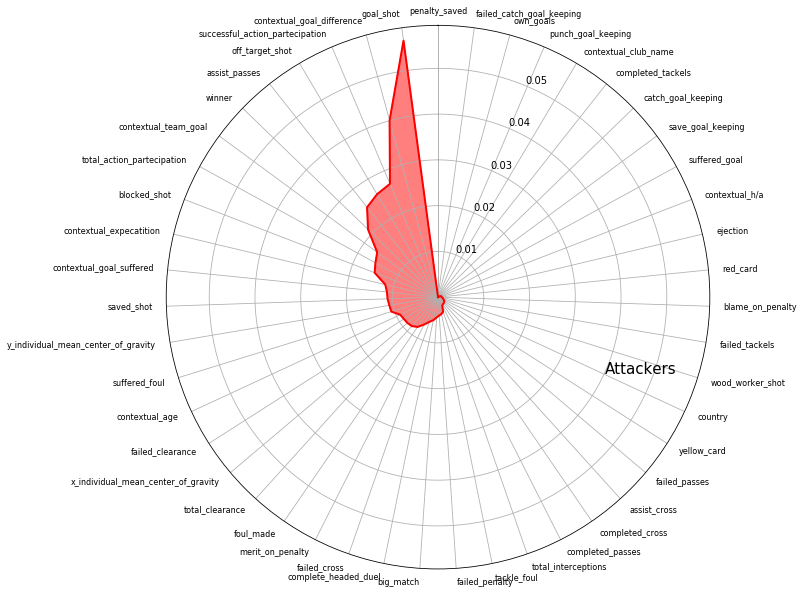

In [13]:
explanation_soccer_analysis.plot_radar_chart(importance_att, 'red', 'Attackers')

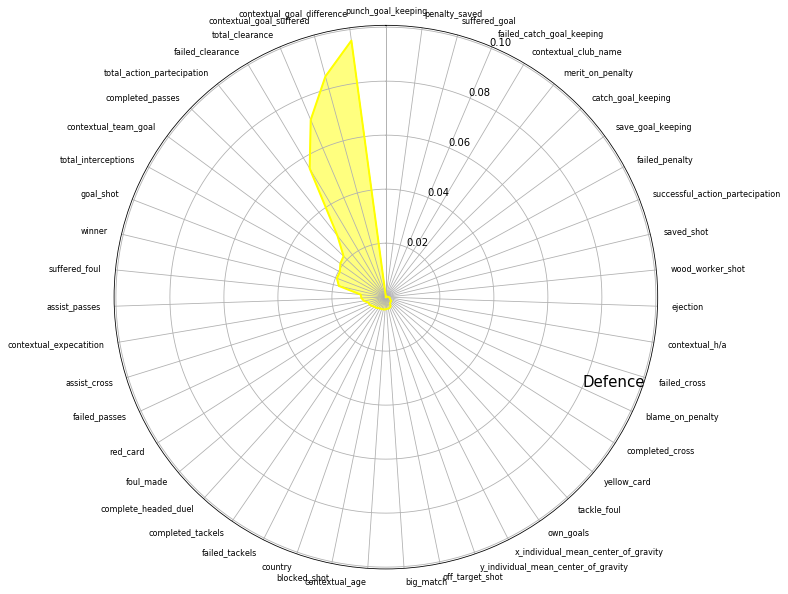

In [14]:
explanation_soccer_analysis.plot_radar_chart(importance_def, 'yellow', 'Defence')

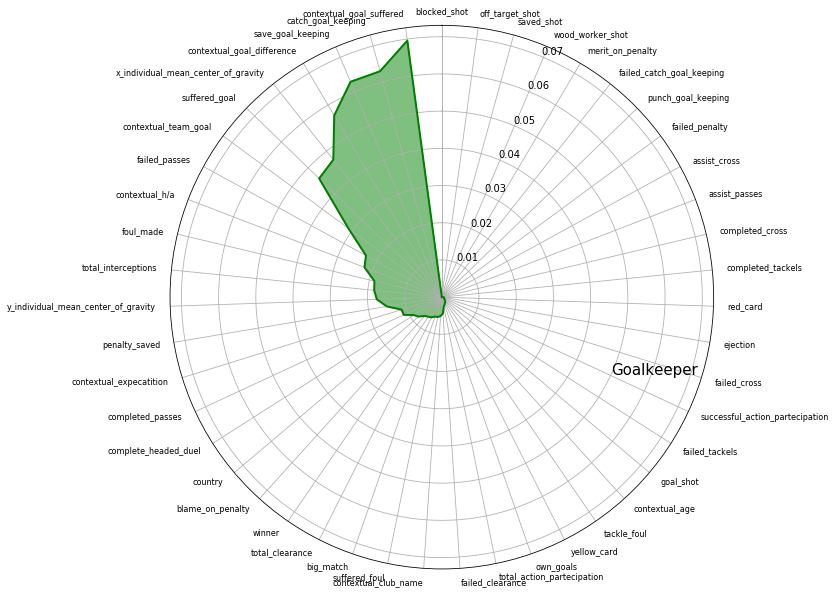

In [15]:
explanation_soccer_analysis.plot_radar_chart(importance_gk, 'green', 'Goalkeeper')

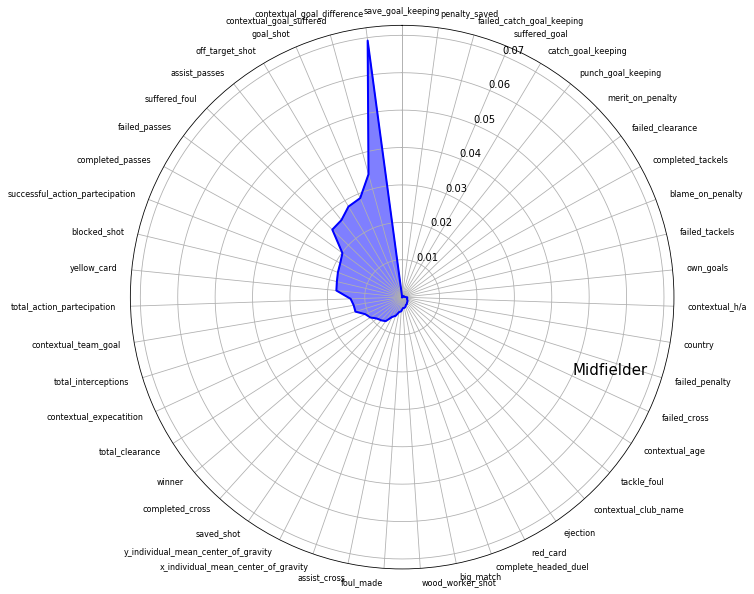

In [16]:
explanation_soccer_analysis.plot_radar_chart(importance_mid, 'blue', 'Midfielder')

## B2. Model Local Explanation Applyied over the mord implementation

For each role we took the the mord implementation that better fit with the dataset, best parameters were computed at the beginning of the notebook.
Then using the trained model and using **SHAP** we computed the shap values selecting those that are interesting in the reason why the model select a specific solution

##### Applyied for Attackers

In [18]:
explainer_att, shap_values_att, predictions_enc_att, predictions_t_att, list_of_motivations_att = explanation_soccer_analysis.locals_explanation_using_shap('load', a_all_score, attacker_labels_training_set, attacker_labels_test_set, 1, attacker_train_set, attacker_test_set,'', integral_att_test_set)

Using 5134 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [19]:
shap.initjs()
shap.force_plot(explainer_att.expected_value[7], shap_values_att[7], attacker_test_set)

##### Applyied for Midfielder

In [20]:
explainer_mid, shap_values_mid, predictions_enc_mid, predictions_t_mid, list_of_motivations_mid = explanation_soccer_analysis.locals_explanation_using_shap('load', c_all_score, mid_labels_training_set, mid_labels_test_set, 0.5, mid_train_set, mid_test_set,'midfielder_', integral_mid_test_set)

Using 9485 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [21]:
shap.force_plot(explainer_mid.expected_value[7], shap_values_mid[7], mid_test_set)

##### Applyied for Defence

In [22]:
explainer_def, shap_values_def, predictions_enc_def, predictions_t_def, list_of_motivations_def = explanation_soccer_analysis.locals_explanation_using_shap('load', d_all_score, def_labels_training_set, def_labels_test_set, 0.7, def_train_set, def_test_set,'defence_', integral_def_test_set)

Using 8640 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [23]:
shap.force_plot(explainer_def.expected_value[7], shap_values_def[7], def_test_set)

#### Applyied for Goalkeeper

In [24]:
explainer_gk, shap_values_gk, predictions_enc_gk, predictions_t_gk, list_of_motivations_gk = explanation_soccer_analysis.locals_explanation_using_shap('load', p_all_score, gk_labels_training_set, gk_labels_test_set, 1, gk_train_set, gk_test_set,'goalkeeper_', integral_gk_test_set)

Using 2013 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [25]:
shap.force_plot(explainer_gk.expected_value[7], shap_values_gk[7], gk_test_set)

In [26]:
pre = [*predictions_t_mid, *predictions_t_att, *predictions_t_def, *predictions_t_gk]

In [27]:
matches = [*list(mid_test_match_id), *list(attacker_test_match_id), *list(def_test_match_id), *list(gk_test_match_id)]

In [28]:
player_id = [*list(mid_test_player_id), *list(attacker_test_player_id), *list(def_test_player_id), *list(gk_test_player_id)]

In [29]:
actual = [*mid_labels_test_set, *attacker_labels_test_set, *def_labels_test_set, *gk_labels_test_set]

In [30]:
teams = [*mid_test_team_id, *attacker_test_team_id, *def_test_team_id, *gk_test_team_id]

In [31]:
motivations = [*list_of_motivations_mid, *list_of_motivations_att, *list_of_motivations_def, *list_of_motivations_gk]

In [32]:
role = [*mid_test_role, *attacker_test_role, *def_test_role, *gk_test_role]

In [33]:
dataset_for_experiment = pd.DataFrame()
dataset_for_experiment['match_id'] = matches
dataset_for_experiment['team_id'] = teams
dataset_for_experiment['player_name'] = player_id
dataset_for_experiment['human_perception'] = " "
dataset_for_experiment['model_prediction'] = pre
dataset_for_experiment['real_prediction'] = actual
dataset_for_experiment['prediction_motivations'] = motivations
dataset_for_experiment['role'] = role

In [34]:
matches_label = []
for row in dataset_for_experiment.values:
    for ma in dfmatc.values:
        if(row[0] == ma[13]):
            matches_label.append(ma[5])

In [35]:
dataset_for_experiment['match_label'] = matches_label

In [36]:
dataset_for_experiment.sort_values(['match_id', 'team_id'])

match_id  team_id   player_name human_perception  model_prediction  \
83    2759498     3158       PASTORE                                6.0   
84    2759498     3158      DE ROSSI                                6.5   
85    2759498     3158        NZONZI                                6.0   
136   2759498     3158   EL SHAARAWY                                6.0   
220   2759498     3158         FAZIO                                7.0   
..        ...      ...           ...              ...               ...   
139   2759803     3193     ZUKANOVIC                                6.0   
140   2759803     3193      CRISCITO                                6.5   
141   2759803     3193        GUNTER                                6.0   
142   2759803     3193  PEZZELLA GIU                                5.0   
224   2759803     3193        RADU I                                6.0   

     real_prediction                             prediction_motivations role  \
83               6.0  {'total_passes_contribution_feature': 0.046583...    C   
84               6.5  {'contextual_goal_difference': 2, 'key_passes'...    C   
85               6.0  {'total_passes_contribution_feature': 0.114906...    C   
136              5.0  {'goals': 0, 'contextual_goal_difference': 2, ...    A   
220              5.5  {'goal_shot': 1, 'goals': 1, 'contextual_goal_...    D   
..               ...                                                ...  ...   
139              6.0  {'total_passes_contribution_feature': 0.150289...    D   
140              7.0      {'goal_shot': 1, 'goals': 1, 'total_shot': 3}    D   
141              5.0  {'total_passes_contribution_feature': 0.164739...    D   
142              4.5  {'red_card': 1, 'total_passes_contribution_fea...    D   
224              6.5  {'catch_goal_keeping': 2, 'save_goal_keeping':...    P   

                 match_label  
83       Roma - Lazio, 3 - 1  
84       Roma - Lazio, 3 - 1  
85       Roma - Lazio, 3 - 1  
136      Roma - Lazio, 3 - 1  
220      Roma - Lazio, 3 - 1  
..                       ...  
139  Genoa - Cagliari, 1 - 1  
140  Genoa - Cagliari, 1 - 1  
141  Genoa - Cagliari, 1 - 1  
142  Genoa - Cagliari, 1 - 1  
224  Genoa - Cagliari, 1 - 1  

[243 rows x 9 columns]

In [37]:
dataset_for_experiment.to_csv(os.path.join(DATA_DATAPATH, 'dataset_for_experiment.csv'), index = False)

# Some explanation examples

I will figure out an explanation for each role. 
1 mid 
1 att
1 def
1 gk

Attacker CRISTIANO RONALDO 7.0

In [38]:
attacker_test_set.loc[47]
doc_num = 47
print('Actual Label:', attacker_labels_test_set.iloc[doc_num])
print('Predicted Label:', predictions_t_att[doc_num])

Actual Label: 7.0
Predicted Label: 7.0


In [39]:
#first 2 index of expected and shap values mean the class, the result is the probability assigned to that class
shap.force_plot(explainer_att.expected_value[6], shap_values_att[6][47,:], integral_att_test_set.reset_index(drop=True).iloc[47,:])

Midfielder IVAN PERISIC 6.5 22

In [40]:
mid_test_set.loc[84]
doc_num = 84
print('Actual Label:', mid_labels_test_set.iloc[doc_num])
print('Predicted Label:',predictions_t_mid[doc_num])

Actual Label: 6.5
Predicted Label: 6.5


In [41]:
#first 2 index of expected and shap values mean the class, the result is the probability assigned to that class
shap.force_plot(explainer_mid.expected_value[6], shap_values_mid[6][84,:], integral_mid_test_set.reset_index(drop=True).iloc[84,:])

Defender BASTOS 5.0 12

In [42]:
def_test_set.loc[12]
doc_num = 12
print('Actual Label:', def_labels_test_set.iloc[doc_num])
print('Predicted Label:', predictions_t_def[doc_num])

Actual Label: 5.0
Predicted Label: 5.0


In [43]:
#first 2 index of expected and shap values mean the class, the result is the probability assigned to that class
shap.force_plot(explainer_def.expected_value[4], shap_values_def[4][12,:], integral_def_test_set.reset_index(drop=True).iloc[12,:])

Goalkeeper SCKESNY 7.0 17

In [44]:
gk_test_set.loc[17]
doc_num = 17
print('Actual Label:', gk_labels_test_set.iloc[doc_num])
print('Predicted Label:', predictions_t_gk[doc_num])

Actual Label: 7.0
Predicted Label: 7.0


In [45]:
#first 2 index of expected and shap values mean the class, the result is the probability assigned to that class
shap.force_plot(explainer_gk.expected_value[7], shap_values_gk[7][17,:], integral_gk_test_set.reset_index(drop=True).iloc[17,:])

## B3. GLOCAL EXPLANATIONS

For each role, for each ratings we compute those features that influences the most the probability of predicting that class.

### Forward role

4.5 Explanations

Text(-0.03, 20, 'Forward (Rating 4.5)')

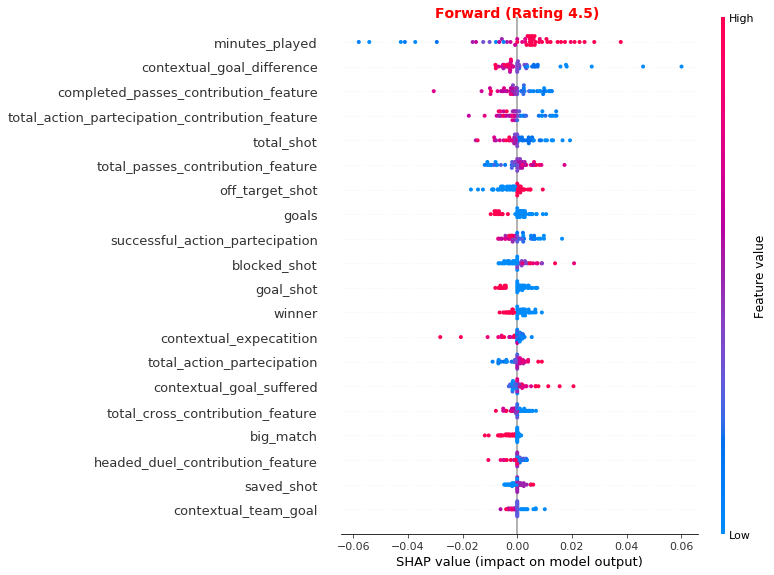

In [46]:
plt.figure(figsize=(40,20))
shap.summary_plot(shap_values_att[1], integral_att_test_set, show=False)
plt.text(-0.03,20,'Forward (Rating 4.5)', fontsize=14, fontweight='bold', color='red')
#name_figure = 'att_glocal_explanation_45.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5 explanations

Text(-0.12, 20, 'Forward (Rating 5)')

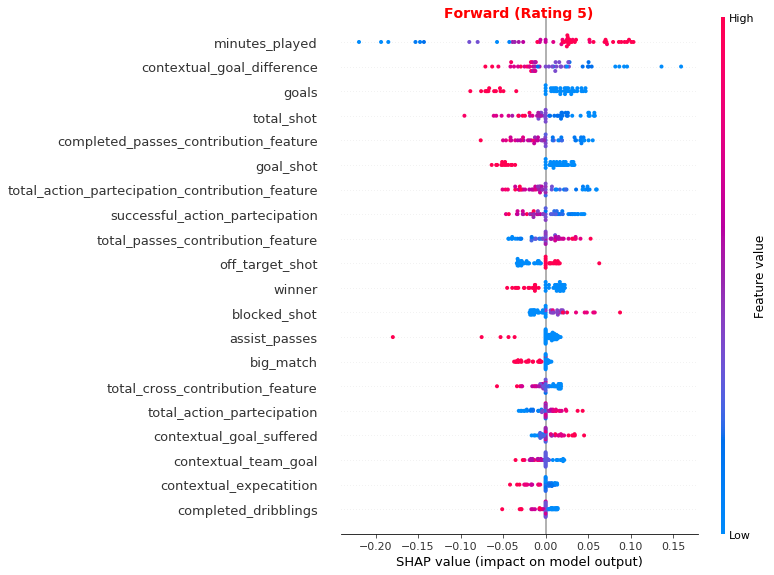

In [47]:
plt.figure(figsize=(40,20))
shap.summary_plot(shap_values_att[2], integral_att_test_set, show=False)
plt.text(-0.12,20,'Forward (Rating 5)', fontsize=14, fontweight='bold', color='red')
#name_figure = 'att_glocal_explanation_5.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5.5 explanations

Text(-0.1, 20, 'Forward (Rating 5.5)')

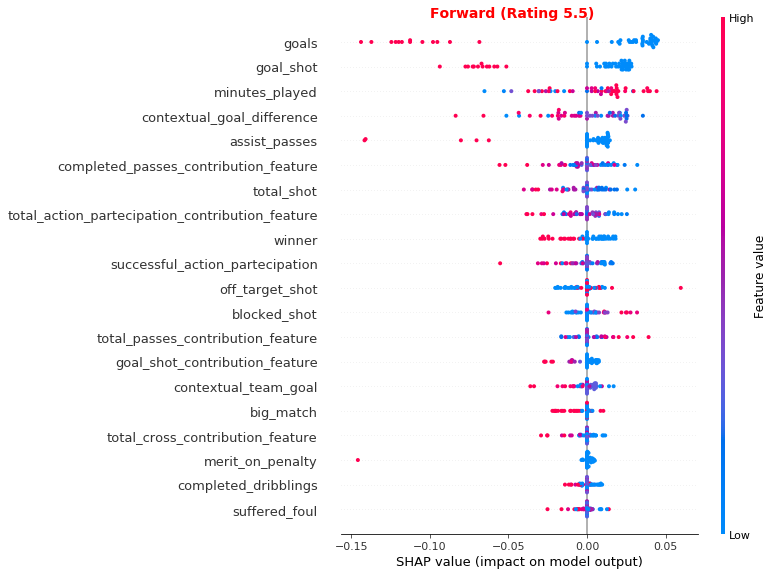

In [48]:
shap.summary_plot(shap_values_att[3], integral_att_test_set, show=False)
plt.text(-0.10,20,'Forward (Rating 5.5)', fontsize=14, fontweight='bold', color='red')
#name_figure = 'att_glocal_explanation_55.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6 explanations

Text(-0.08, 20, 'Forward (Rating 6)')

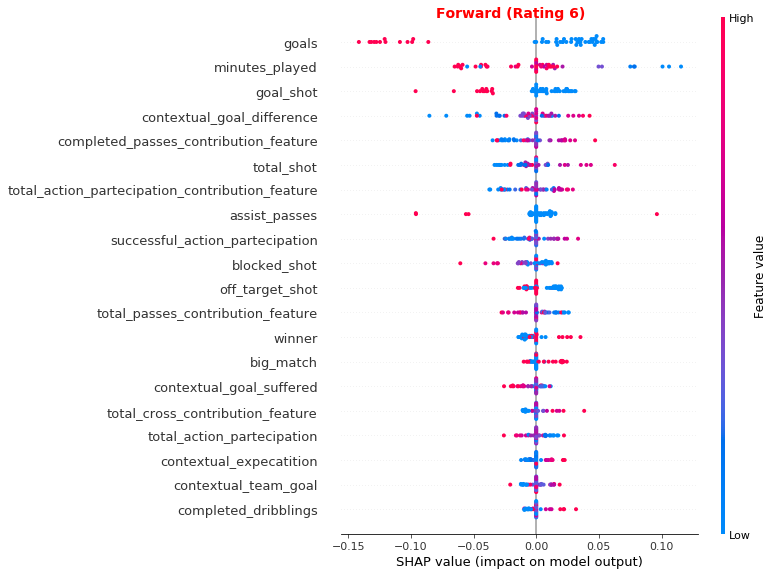

In [49]:
shap.summary_plot(shap_values_att[4], integral_att_test_set, show=False)
plt.text(-0.08,20,'Forward (Rating 6)', fontsize=14, fontweight='bold', color='red')
#name_figure = 'att_glocal_explanation_6.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6.5 explanations

Text(-0.1, 20, 'Forward (Rating 6.5)')

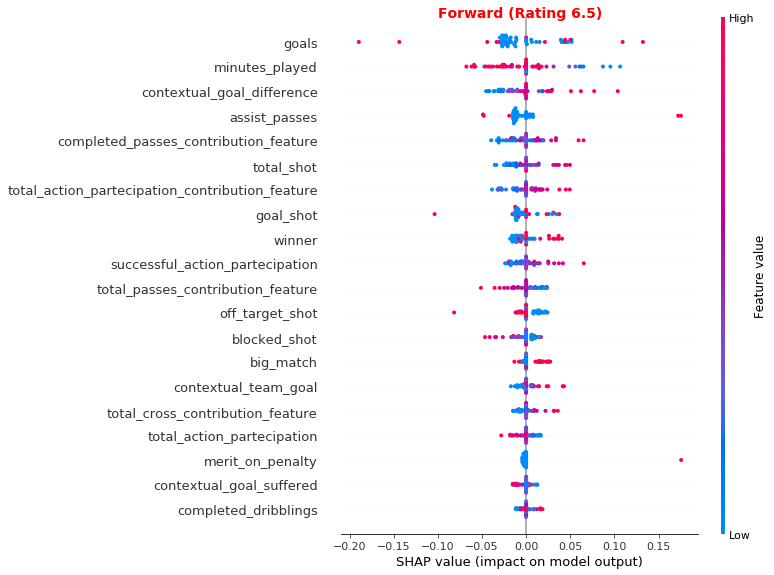

In [50]:
shap.summary_plot(shap_values_att[5], integral_att_test_set, show=False)
plt.text(-0.10,20,'Forward (Rating 6.5)', fontsize=14, fontweight='bold', color='red')
#name_figure = 'att_glocal_explanation_65.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

7 explanations

Text(-0.08, 20, 'Forward (Rating 7)')

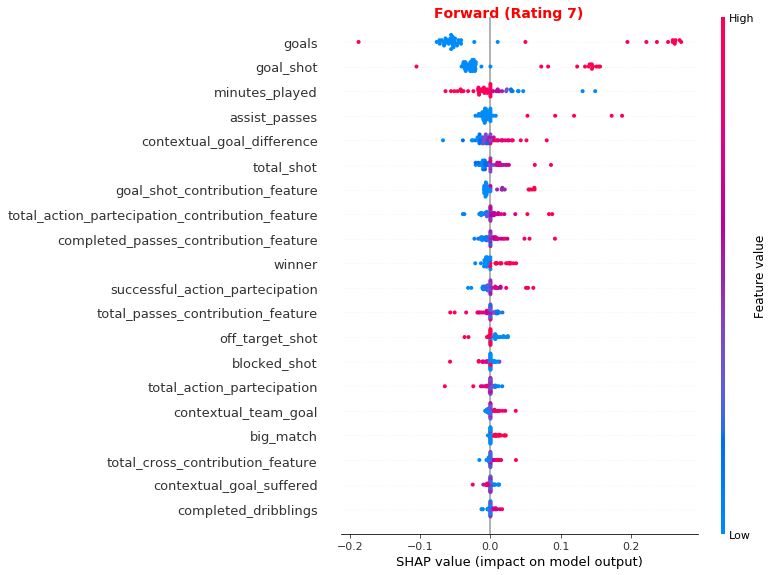

In [51]:
shap.summary_plot(shap_values_att[6], integral_att_test_set, show=False)
plt.text(-0.08,20,'Forward (Rating 7)', fontsize=14, fontweight='bold', color='red')
#name_figure = 'att_glocal_explanation_7.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

### Midfielder Role

4.5 explanations

Text(-0.04, 20, 'Midfielder (Rating 4.5)')

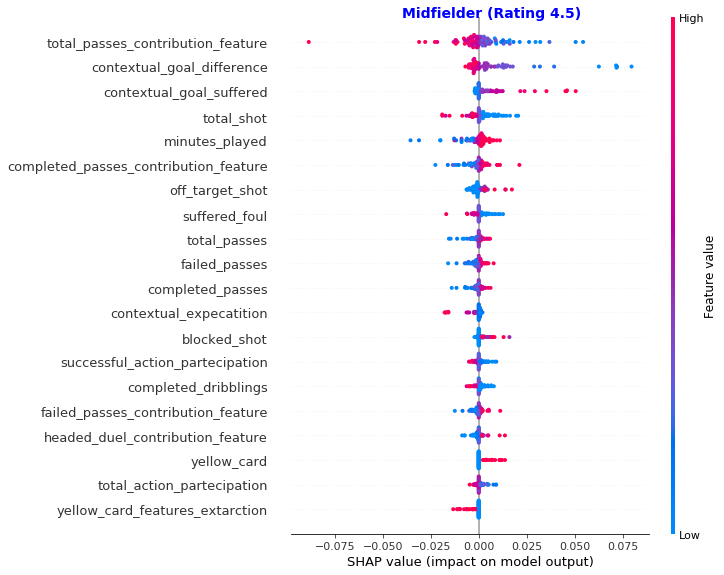

In [52]:
shap.summary_plot(shap_values_mid[2], integral_mid_test_set, show=False)
plt.text(-0.04,20,'Midfielder (Rating 4.5)', fontsize=14, fontweight='bold', color='blue')
#name_figure = 'mid_glocal_explanation_45.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5 explanations

Text(-0.09, 20, 'Midfielder (Rating 5)')

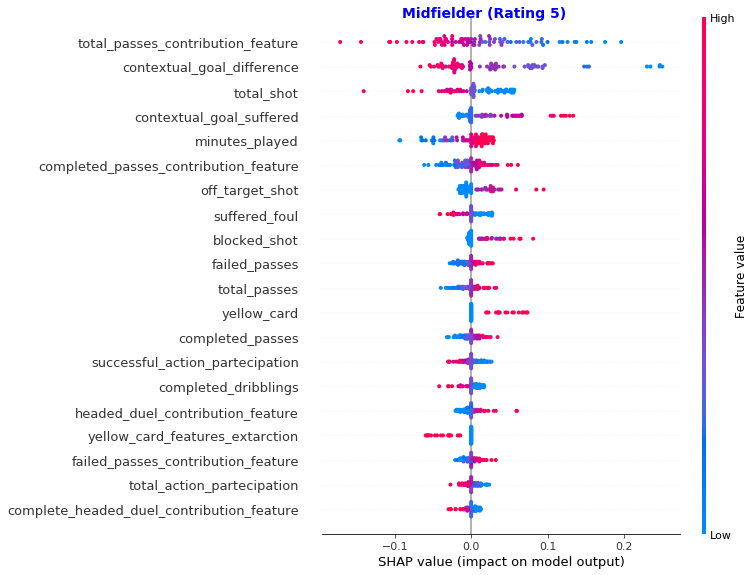

In [53]:
shap.summary_plot(shap_values_mid[3], integral_mid_test_set, show=False)
plt.text(-0.09,20,'Midfielder (Rating 5)', fontsize=14, fontweight='bold', color='blue')
#name_figure = 'mid_glocal_explanation_5.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5.5 explanations

Text(-0.1, 20, 'Midfielder (Rating 5.5)')

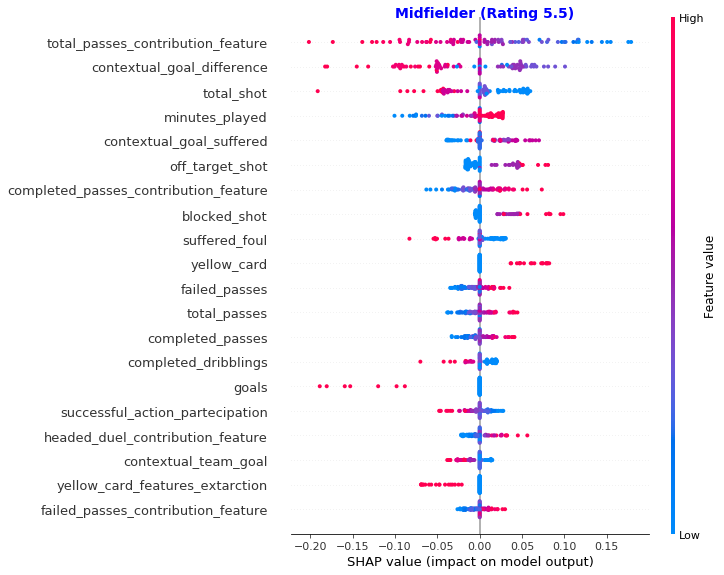

In [54]:
shap.summary_plot(shap_values_mid[4], integral_mid_test_set, show=False)
plt.text(-0.10,20,'Midfielder (Rating 5.5)', fontsize=14, fontweight='bold', color='blue')
#name_figure = 'mid_glocal_explanation_55.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6 explanations

Text(-0.17, 20, 'Midfielder (Rating 6)')

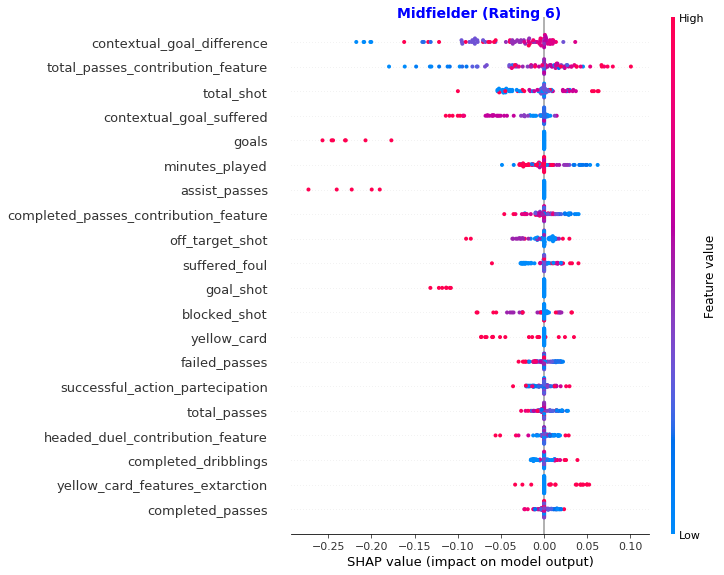

In [55]:
shap.summary_plot(shap_values_mid[5], integral_mid_test_set, show=False)
plt.text(-0.17,20,'Midfielder (Rating 6)', fontsize=14, fontweight='bold', color='blue')
#name_figure = 'mid_glocal_explanation_6.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6.5 explanations

Text(-0.1, 20, 'Midfielder (Rating 6.5)')

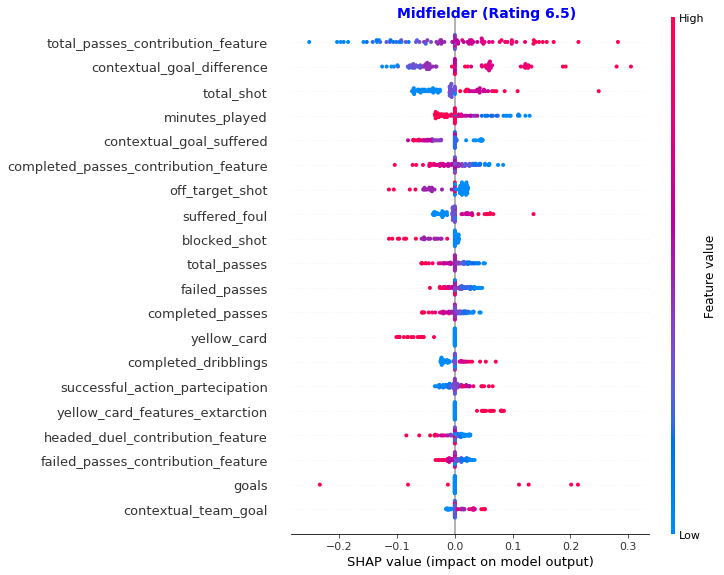

In [56]:
shap.summary_plot(shap_values_mid[6], integral_mid_test_set, show=False)
plt.text(-0.10,20,'Midfielder (Rating 6.5)', fontsize=14, fontweight='bold', color='blue')
#name_figure = 'mid_glocal_explanation_65.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

7 explanations

Text(0.05, 20, 'Midfielder (Rating 7)')

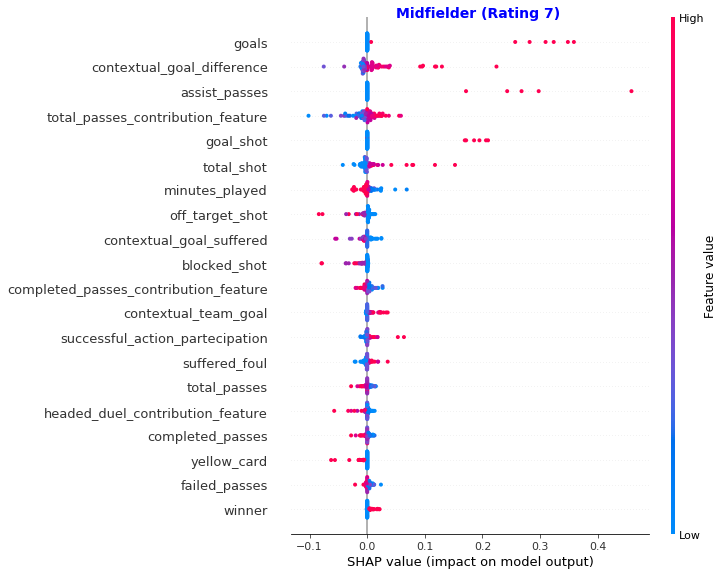

In [57]:
shap.summary_plot(shap_values_mid[7], integral_mid_test_set, show=False)
plt.text(0.05,20,'Midfielder (Rating 7)', fontsize=14, fontweight='bold', color='blue')
#name_figure = 'mid_glocal_explanation_7.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

### Defence Role
4.5 Explanations

Text(-0.03, 20, 'Defender (Rating 4.5)')

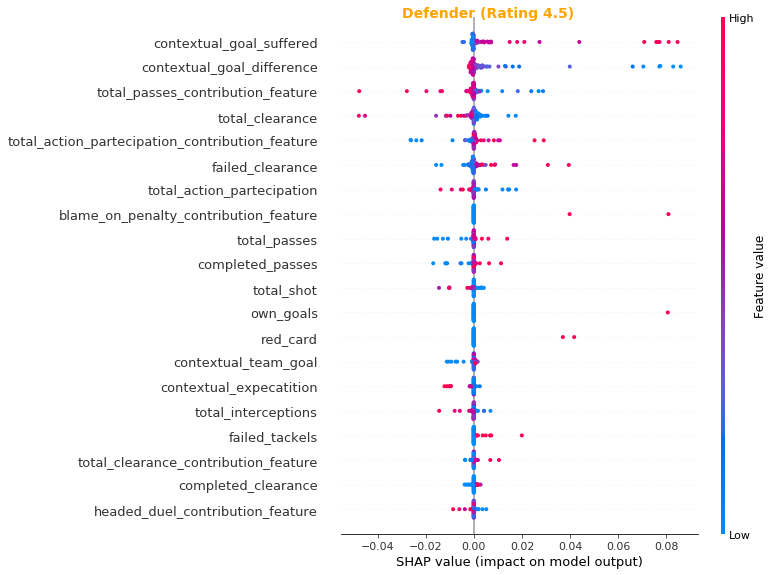

In [58]:
shap.summary_plot(shap_values_def[2], integral_def_test_set, show=False)
plt.text(-0.03,20,'Defender (Rating 4.5)', fontsize=14, fontweight='bold', color='orange')
#name_figure = 'def_glocal_explanation_45.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5 explanations

Text(-0.04, 20, 'Defender (Rating 5)')

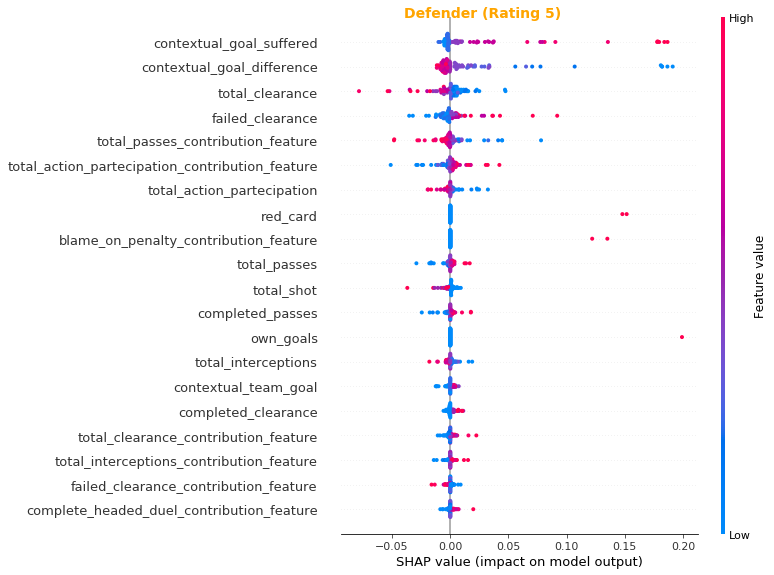

In [59]:
shap.summary_plot(shap_values_def[3], integral_def_test_set, show=False)
plt.text(-0.04,20,'Defender (Rating 5)', fontsize=14, fontweight='bold', color='orange')
#name_figure = 'def_glocal_explanation_5.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5.5 explanations

Text(-0.19, 20, 'Defender (Rating 5.5)')

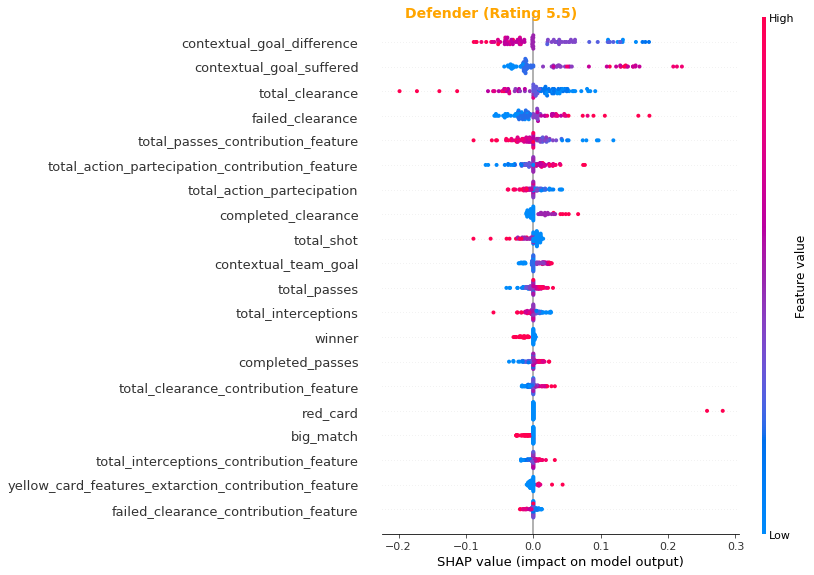

In [60]:
shap.summary_plot(shap_values_def[4], integral_def_test_set, show=False)
plt.text(-0.19,20,'Defender (Rating 5.5)', fontsize=14, fontweight='bold', color='orange')
#name_figure = 'def_glocal_explanation_55.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6 explanations

Text(-0.18, 20, 'Defender (Rating 6)')

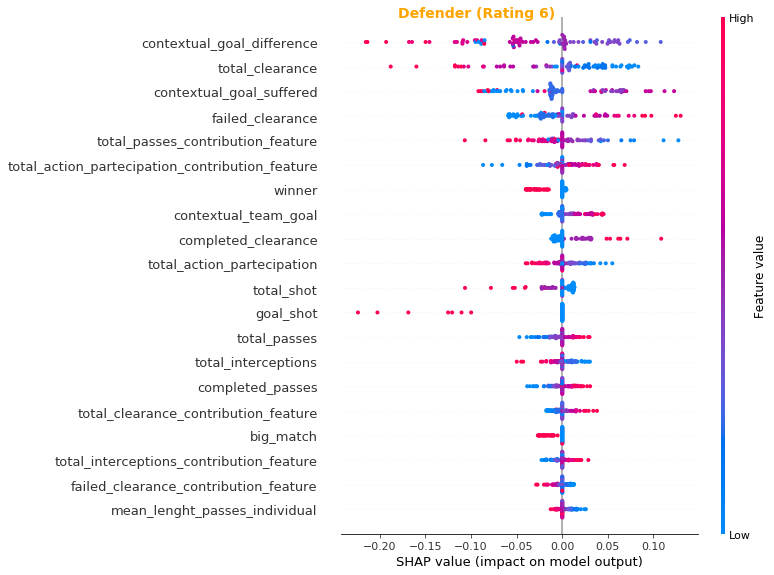

In [61]:
shap.summary_plot(shap_values_def[5], integral_def_test_set, show=False)
plt.text(-0.18,20,'Defender (Rating 6)', fontsize=14, fontweight='bold', color='orange')
#name_figure = 'def_glocal_explanation_6.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6.5 explanations

Text(-0.25, 20, 'Defender (Rating 6.5)')

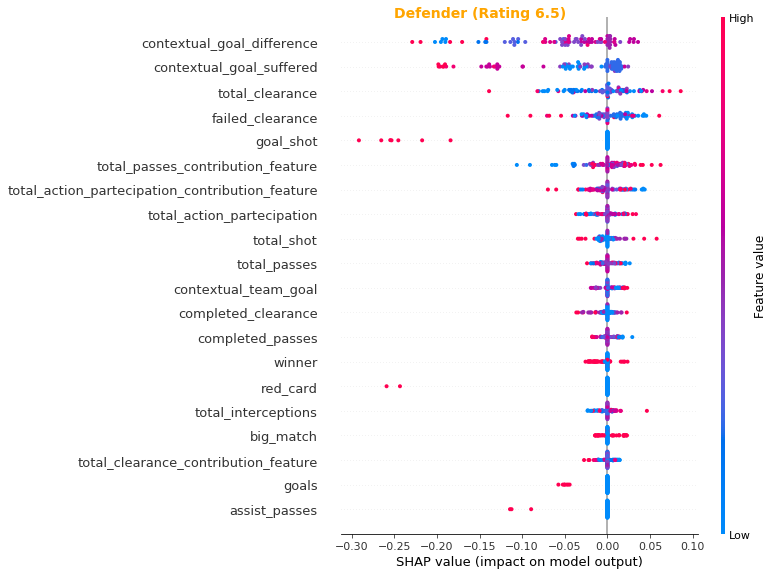

In [62]:
shap.summary_plot(shap_values_def[6], integral_def_test_set, show=False)
plt.text(-0.25,20,'Defender (Rating 6.5)', fontsize=14, fontweight='bold', color='orange')
#name_figure = 'def_glocal_explanation_65.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

7 explanations

Text(-0.15, 20, 'Defender (Rating 7)')

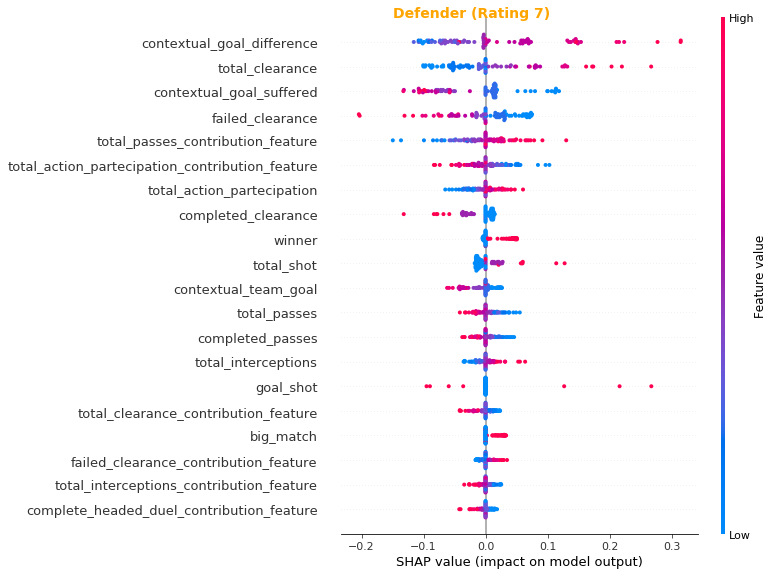

In [63]:
shap.summary_plot(shap_values_def[7], integral_def_test_set, show=False)
plt.text(-0.15,20,'Defender (Rating 7)', fontsize=14, fontweight='bold', color='orange')
#name_figure = 'def_glocal_explanation_7.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

### Goalkeeper Role
4.5 Explanations

Text(-0.01, 20, 'Goalkeeper (Rating 4.5)')

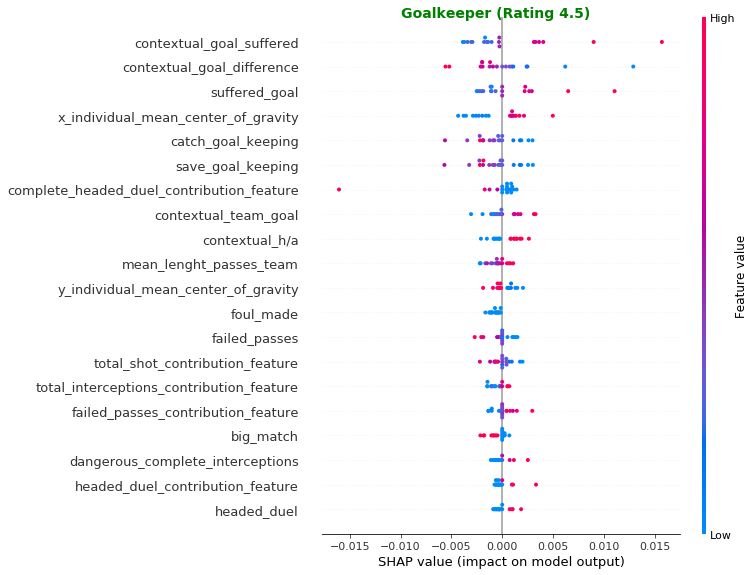

In [64]:
shap.summary_plot(shap_values_gk[2], integral_gk_test_set, show=False)
plt.text(-0.010,20,'Goalkeeper (Rating 4.5)', fontsize=14, fontweight='bold', color='green')
#name_figure = 'gk_glocal_explanation_45.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5 explanations

Text(-0.035, 20, 'Goalkeeper (Rating 5)')

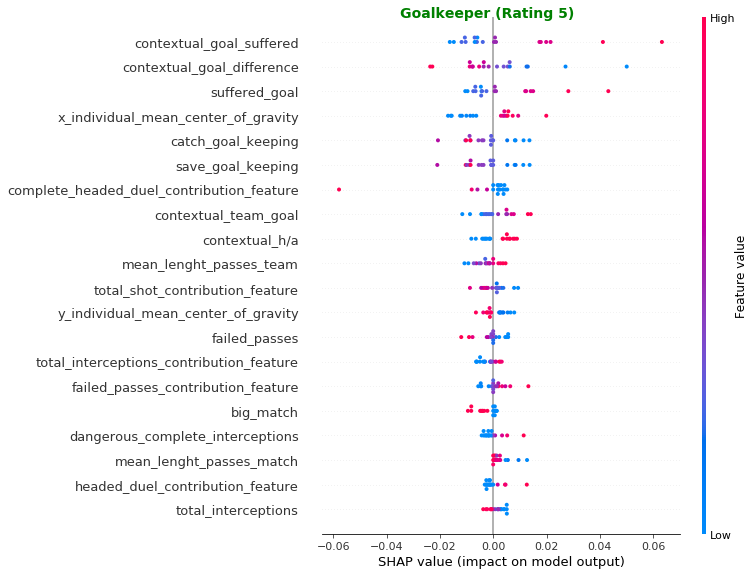

In [65]:
shap.summary_plot(shap_values_gk[3], integral_gk_test_set, show=False)
plt.text(-0.035,20,'Goalkeeper (Rating 5)', fontsize=14, fontweight='bold', color='green')
#name_figure = 'gk_glocal_explanation_5.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

5.5 explanations

Text(-0.037, 20, 'Goalkeeper (Rating 5.5)')

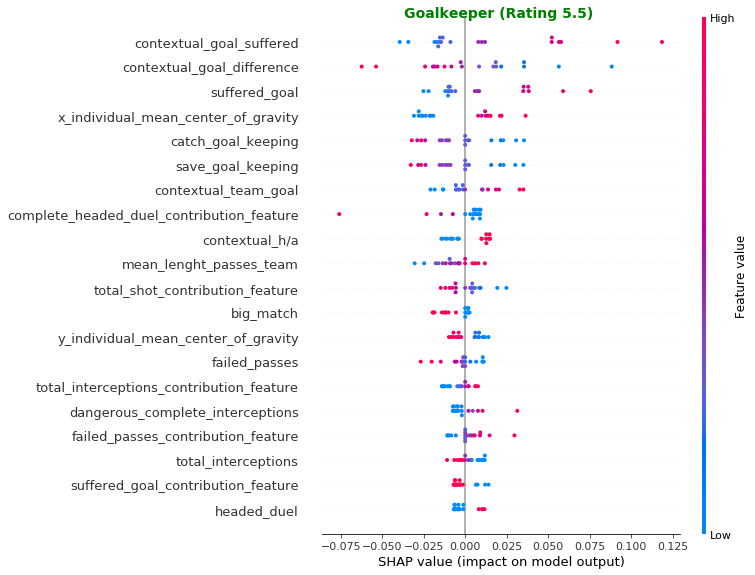

In [66]:
shap.summary_plot(shap_values_gk[4], integral_gk_test_set, show=False)
plt.text(-0.037,20,'Goalkeeper (Rating 5.5)', fontsize=14, fontweight='bold', color='green')
#name_figure = 'gk_glocal_explanation_55.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6 explanations

Text(-0.107, 20, 'Goalkeeper (Rating 6)')

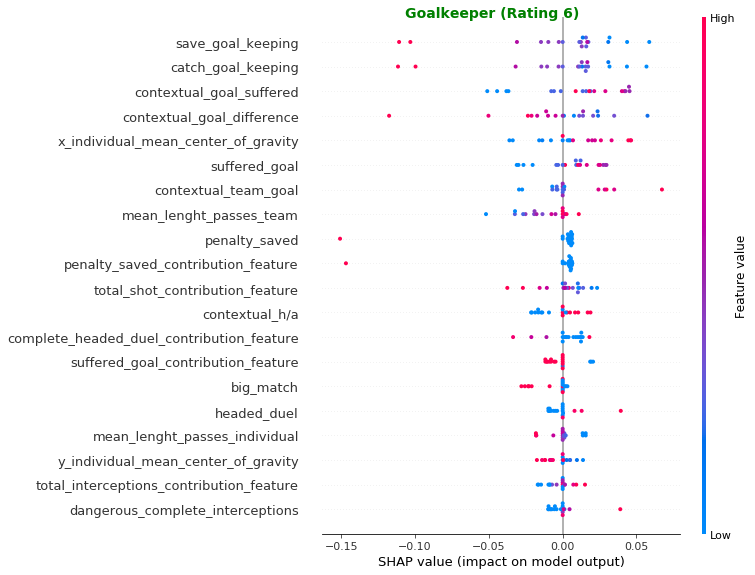

In [67]:
shap.summary_plot(shap_values_gk[5], integral_gk_test_set, show=False)
plt.text(-0.107,20,'Goalkeeper (Rating 6)', fontsize=14, fontweight='bold', color='green')
#name_figure = 'gk_glocal_explanation_6.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

6.5 explanations

Text(-0.09, 20, 'Goalkeeper (Rating 6.5)')

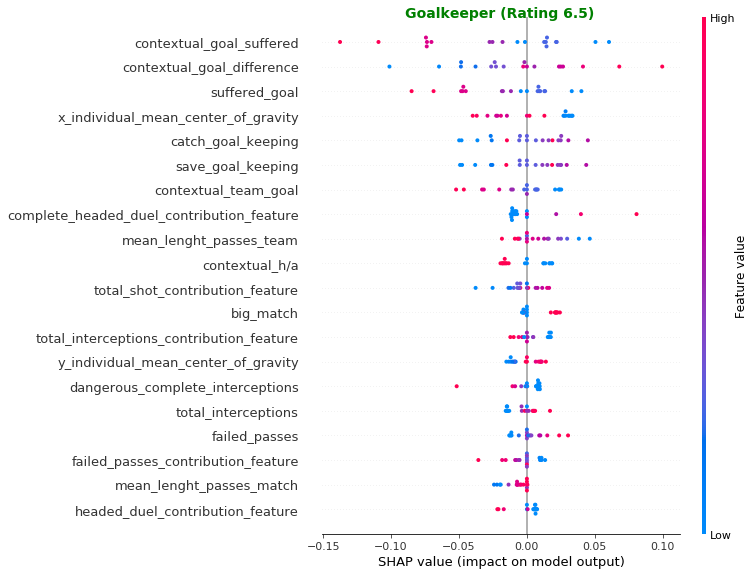

In [68]:
shap.summary_plot(shap_values_gk[6], integral_gk_test_set, show=False)
plt.text(-0.09,20,'Goalkeeper (Rating 6.5)', fontsize=14, fontweight='bold', color='green')
#name_figure = 'gk_glocal_explanation_65.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))

7 explanations

Text(-0.028, 20, 'Goalkeeper (Rating 7)')

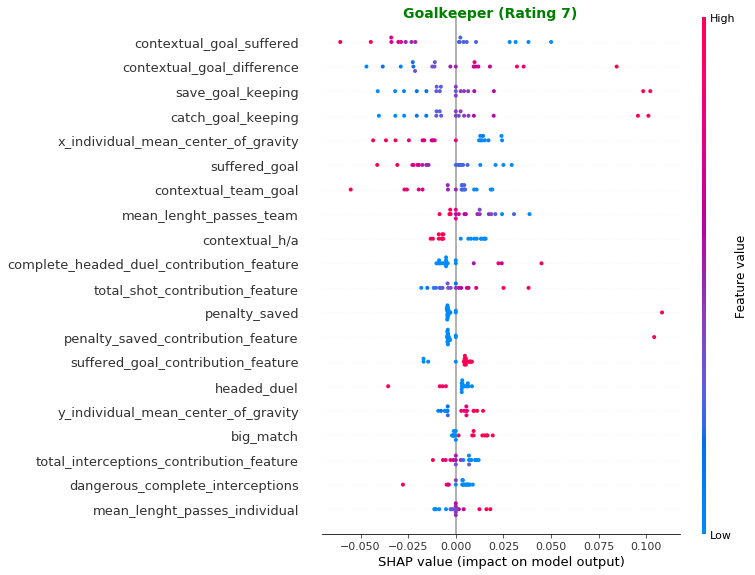

In [69]:
shap.summary_plot(shap_values_gk[7], integral_gk_test_set, show=False)
plt.text(-0.028,20,'Goalkeeper (Rating 7)', fontsize=14, fontweight='bold', color='green')
#name_figure = 'gk_glocal_explanation_7.pdf'
#plt.savefig(os.path.join(IMG_DATAPATH, name_figure))